In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from s_dbw import S_Dbw
import math
import matplotlib.patches as mpatches


In [2]:
# resets index after selections have been made
def resetindex(data):
    data=data.reset_index()
    data=data.drop('index', axis=1)
    return data

In [3]:
#reduces the data set to the first m iterations
def firstiterations(m,data):
    i=0
    j=0
    n=len(data.index)    
    while i<n:
        if  (data.iat[j,10]>m):
            data=data.drop(i, axis=0)
            i=i+1
        else:
            i=i+1
            j=j+1
    data=resetindex(data)
    return data

In [4]:
# Generate a Series with a specific length, so that all residuals of one parameter combination are in one line
def GenerateSeries(source, Length):
    output=source.iloc[:,[4,5]]
    output=output.drop_duplicates()
    output=resetindex(output)
    for j in range(1, Length+1):
        output[f'ResidualNorm{j}']=0.0
        for i in range(len(output.index)):
            Abfrage=source.query( f"`Droptol`=={output.iat[i,0]} and `Fillfactor`=={output.iat[i,1]} and Iterations=={j}")
            if len(Abfrage.index)==1:
                output.iat[i,j+1]=Abfrage.iat[0,8]
            elif len(Abfrage.index)>1:
                raise Exception("Multiple instances with same Droptol, Fillfactor and Iteration within one Beta")
    return output

In [5]:
#df=pd.read_csv('thermal1.txt', sep='\t', header=None)
df = pd.read_csv("Ex02.csv", sep=',', header=None,error_bad_lines=False)



b'Skipping line 7: expected 273 fields, saw 505\nSkipping line 8: expected 273 fields, saw 549\nSkipping line 9: expected 273 fields, saw 549\nSkipping line 16: expected 273 fields, saw 483\nSkipping line 17: expected 273 fields, saw 549\nSkipping line 18: expected 273 fields, saw 549\nSkipping line 25: expected 273 fields, saw 483\nSkipping line 26: expected 273 fields, saw 549\nSkipping line 27: expected 273 fields, saw 549\nSkipping line 34: expected 273 fields, saw 483\nSkipping line 35: expected 273 fields, saw 549\nSkipping line 36: expected 273 fields, saw 549\nSkipping line 43: expected 273 fields, saw 483\nSkipping line 44: expected 273 fields, saw 549\nSkipping line 45: expected 273 fields, saw 549\nSkipping line 52: expected 273 fields, saw 483\nSkipping line 53: expected 273 fields, saw 549\nSkipping line 54: expected 273 fields, saw 549\nSkipping line 61: expected 273 fields, saw 483\nSkipping line 62: expected 273 fields, saw 549\nSkipping line 63: expected 273 fields, sa

In [6]:
temp,columnscount=df.shape
df=df.fillna(0)

In [7]:
df = df.rename(columns={0: 'Fillfactor', 1: 'Droptol',2: 'Nonzeros'})

In [8]:
#df=df.query("Fillfactor>1")

In [9]:
#test different combinations and compute S_Dbw score
clustermax=12
optimizationgrid=np.zeros(clustermax-2)
scaler = preprocessing.StandardScaler().fit(df.iloc[:,3:columnscount-1:2])
scaled_clusterdata=scaler.transform(df.iloc[:,3:columnscount-1:2])
for clustercount in range(2,clustermax):
    kmeans=KMeans(n_clusters=clustercount)
    y=kmeans.fit_predict(scaled_clusterdata)
    UnsortedClusters=y
    labels=kmeans.labels_
    score = S_Dbw(scaled_clusterdata, labels, centers_id=None, method='Halkidi', alg_noise='bind', centr='mean', nearest_centr=True, metric='euclidean')
    optimizationgrid[clustercount-2]=score

In [13]:
       
    
# take best option based on the score      
minima=np.argwhere((optimizationgrid == np.min(optimizationgrid)))
minima=minima[0]
clustercount=minima[0]+2
#clustercount=11
#series=GenerateSeries(dfBeta,SeriesLength)
scaler = preprocessing.StandardScaler().fit(df.iloc[:,3:columnscount-1:2])
scaled_clusterdata=scaler.transform(df.iloc[:,3:columnscount-1:2])
kmeans=KMeans(n_clusters=clustercount)
y=kmeans.fit_predict(scaled_clusterdata)
UnsortedClusters=y
labels=kmeans.labels_
score = S_Dbw(scaled_clusterdata, labels, centers_id=None, method='Halkidi', alg_noise='bind', centr='mean', nearest_centr=True, metric='euclidean')


#Sort clusters
SortingValues=np.zeros(clustercount)
SortData=pd.DataFrame(df.iloc[:,columnscount-2])

SortData['UnsortedClusters']=y
for i in range(0,clustercount):
    ResOfCluster=SortData.query(f'UnsortedClusters=={i}')
    #print(ResOfCluster.iloc[:,0])
    sums=(ResOfCluster.iloc[:,0]).sum()
    #print('sums:',sums)
    if sums==0:
        NonzerosInSeries=0
        for j in range(0,len(ResOfCluster.index)):
            ToBeCounted=df.loc[ResOfCluster.index[j],:]
            NonzerosInSeries= NonzerosInSeries+np.count_nonzero(ToBeCounted, axis=0)
        NonzerosInSeries=NonzerosInSeries/len(ResOfCluster.index)
        SortingValues[i]=-1000+NonzerosInSeries
    else:    
        SortingValues[i]=sums/len(ResOfCluster.index)

    
    
Sorting=np.argsort(np.argsort(SortingValues))
Clusters=np.zeros(shape=len(UnsortedClusters))
for i in range(0,len(Clusters)):
    Clusters[i]=Sorting[UnsortedClusters[i]]
Clusters=np.int_(Clusters)

df['Cluster']=Clusters


In [14]:
#Filter and sort provenance data according to constraints and optimization goals
#ILUTNonzerosLimit=76000
#ProvenanceData
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(resetindex((ProvenanceData.query(f"ILUTNonzeros<{ILUTNonzerosLimit}")).sort_values(by=['Cluster','TimeAtSeriesLengthIteration'])))

<br>
<br>
<br>
<strong> Visualizing parameter space

In [15]:
list=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']
for cl in range(0,clustercount):
    vars()["PredictionGroup"+list[cl]]=df.query(f"`Cluster`=={cl}") #" and ILUTNonzeros<{ILUTNonzerosLimit}")

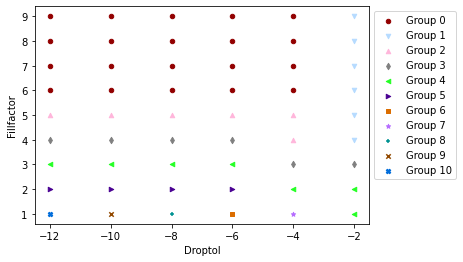

In [16]:
ax = PredictionGroup0.plot(kind='scatter', x='Droptol', y='Fillfactor',color='#920000', label='Group 0');
PredictionGroup1.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "v", color='#b6dbff', label='Group 1', ax=ax);
if clustercount>2:
    PredictionGroup2.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "^", color='#ffb6db', label='Group 2', ax=ax);
    if clustercount>3:
        PredictionGroup3.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "d",color='grey', label='Group 3', ax=ax);
        if clustercount>4:
            PredictionGroup4.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "<",color='#24ff24', label='Group 4', ax=ax);
            if clustercount>5:
                PredictionGroup5.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= ">",color='#490092', label='Group 5', ax=ax);
                if clustercount>6:
                    PredictionGroup6.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "s",color='#db6d00', label='Group 6', ax=ax);
                    if clustercount>7:
                        PredictionGroup7.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "*",color='#b66dff', label='Group 7', ax=ax);
                        if clustercount>8:
                            PredictionGroup8.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "+",color='#009292', label='Group 8', ax=ax);
                            if clustercount>9:
                                PredictionGroup9.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "x", color='#924900', label='Group 9', ax=ax);
                                if clustercount>10:
                                    PredictionGroup10.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "X",color='#006ddb', label='Group 10', ax=ax);
                                    if clustercount>11:
                                        PredictionGroup11.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "D",color='#004949', label='Group 11', ax=ax);
#ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.0, 1.0))
#plt.title(f"Beta=1e{int(math.log10(beta))}, full dataset, all iterations, ILUTNonzeros<{ILUTNonzerosLimit}")
plt.show()

<br>
<br>
<br>
<strong> Visualizing trajectories

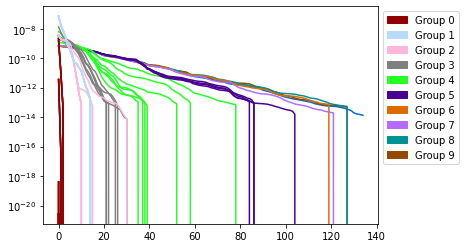

In [17]:
colors=['#920000','#b6dbff','#ffb6db','grey','#24ff24','#490092','#db6d00','#b66dff','#009292','#924900','#006ddb','#004949']
length=len(df.index)
liste=[None] * length
for i in range(0,length):
    liste[i-1]=df.iloc[i,3:columnscount:2]
for i in range(0,length):
    #if df.iloc[i,columnscount]>2:
    liste[i-1].plot(use_index=False, color=colors[df.iloc[i,columnscount]])#, label=f'Group {df.iloc[i,1003]}')

affiliation=[None] * 10
for i in range(0,10):
    affiliation[i]= mpatches.Patch(color=colors[i], label=f'Group {i}')

plt.legend(handles=affiliation,bbox_to_anchor=(1.0, 1.0))
plt.yscale("log")
#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()